In [ ]:
# import the necessary packages
import numpy as np
import gzip, os
from urllib.request import urlretrieve
from random import random
from math import exp
from random import seed
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Background
In this project, you will use PyTorch to train neural networks for the tasks of image classification and image segemntation.

If you are not familiar with PyTorch, this [tutorial](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html) guides you through how you write a training loop to train a PyTorch model.
You can basically follow the tutorial to do Part 1, and you can use the classifier model in the tutorial as a reference to build the model we describe.

The overall pipeline for training a model in PyTorch is:
- load the data
- build a model
- setup an optimizer for the model parameters
- choose a criterion (loss function)
- write a training loop that optimizers the model parameters w gradient descent (through the pytorch optimizer)

The main differences between part 1 and 2 would be:
- The labels (image classes v.s. per pixel class)
- The model (in part 1, you predict a class per image, while in part 2 you need to predict class per pixel)
- The loss

**Note: Colab allows you to use GPU, so make sure to use that to speed up training**
You can simply move everything to the gpu in PyTorch by calling cuda() on your model and parameters like this:

```
model = model.cuda()
data_x = data_x.cuda()
labels = labels.cuda()

```




# Part 1: Training an Image Classifier




##Overview
CIFAR10 dataset will be used to train an image classifier.

![](https://miro.medium.com/max/578/1*BCsHErqOJxmKDLQXYJR_ow.png)



##Data
Using `torchvision`, it’s extremely easy to load `CIFAR10`.

In [ ]:
## The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 65799887.21it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


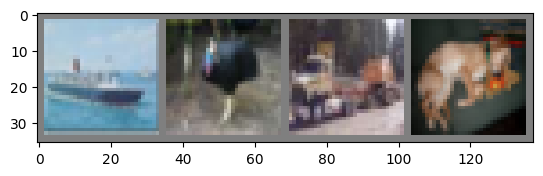

ship  bird  truck dog  


In [ ]:
## Let us show some of the training images, for fun.

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

##Code (20 pts)

###Define a Convolutional Neural Network (10 pt)

Create a neural network that take 3-channel images. It should go as Conv2d --> ReLU --> MaxPool2d --> Conv2d --> ReLU --> MaxPool2d --> Flatten --> Linear --> ReLU --> Linear --> ReLU --> Linear

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        ## TODO: Add layers to your neural net.
        # you should be able to use PyTorch layers to construct the layers based on the description above.
        # see the tutorial if not familiar on how to do this
        # Define the conv2d layers taking 3 channels input
        self.c1 = nn.Conv2d(3,6,5)
        self.c2 = nn.Conv2d(6,16,5)
        # Define the linear transformation
        self.lin1 = nn.Linear(16*5*5,120)   #test it to see if you have to multiply by 5*5 or is it ok?
        self.lin2 = nn.Linear(120,84)
        self.lin3 = nn.Linear(84,10)



    def forward(self, x):
        ## TODO: run forward pass as mentioned above.
        # First Conv2d --> ReLU --> MaxPool2d over 2by2 window
        x = F.max_pool2d(F.relu(self.c1(x)),2)
        # Second Conv2d --> ReLU --> MaxPool2d
        x = F.max_pool2d(F.relu(self.c2(x)),2)
        # Flatten
        x = x.view(-1, self.num_flat_features(x))
        #x = torch.flatten(x,1)
        # Linear --> ReLU --> Linear --> ReLU --> Linear
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)

        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()

In [ ]:
import torch
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

net.to(device)
print(net)

Using device: cuda
Net(
  (c1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (c2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (lin1): Linear(in_features=400, out_features=120, bias=True)
  (lin2): Linear(in_features=120, out_features=84, bias=True)
  (lin3): Linear(in_features=84, out_features=10, bias=True)
)


###Define a Loss function and optimizer (5 pt)

Let’s use a Classification Cross-Entropy loss and SGD with momentum. (Feel free to experiment with other loss functions and optimizers to observe differences)

In [ ]:
criterion = nn.CrossEntropyLoss() ## Add loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  ## Add optimizer

# Move the loss function to the GPU
criterion = criterion.to(device)

###Train the network (5 pts)

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

[1,  2000] loss: 2.191
[1,  4000] loss: 1.890
[1,  6000] loss: 1.696
[1,  8000] loss: 1.576
[1, 10000] loss: 1.529
[1, 12000] loss: 1.458
[2,  2000] loss: 1.394
[2,  4000] loss: 1.382
[2,  6000] loss: 1.333
[2,  8000] loss: 1.320
[2, 10000] loss: 1.307
[2, 12000] loss: 1.294
[3,  2000] loss: 1.217
[3,  4000] loss: 1.201
[3,  6000] loss: 1.215
[3,  8000] loss: 1.200
[3, 10000] loss: 1.197
[3, 12000] loss: 1.183
[4,  2000] loss: 1.109
[4,  4000] loss: 1.095
[4,  6000] loss: 1.108
[4,  8000] loss: 1.131
[4, 10000] loss: 1.105
[4, 12000] loss: 1.110
Finished Training


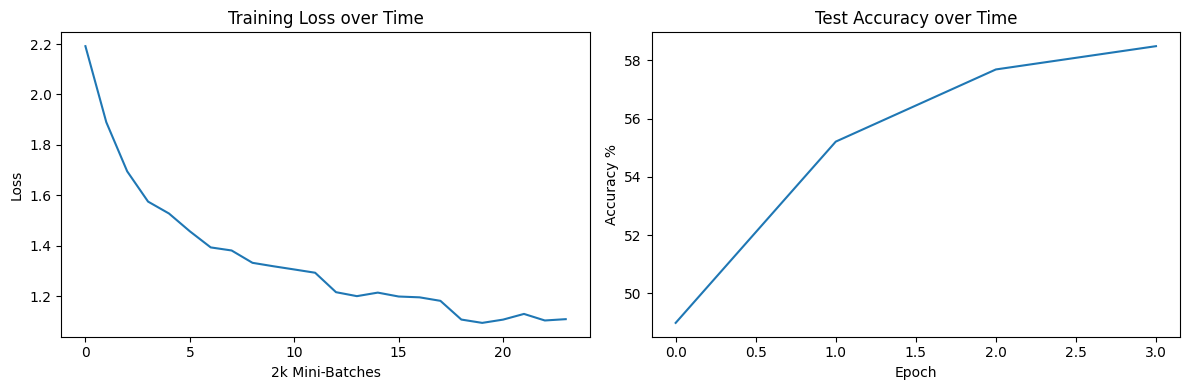

In [ ]:
# Initialize lists to store the loss and accuracy values for plots
loss_values = []
accuracy_values = []

epochs = 4
for epoch in range(epochs):
    running_loss = 0.0
    net.train()

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            # Append the average loss to the list
            loss_values.append(running_loss / 2000)
            running_loss = 0.0

    # Calculate accuracy after each epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy_values.append(100 * correct / total)

print('Finished Training')

# Plot the loss over the epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_values)
plt.title('Training Loss over Time')
plt.xlabel('2k Mini-Batches')
plt.ylabel('Loss')

# Plot the accuracy over the epochs
plt.subplot(1, 2, 2)
plt.plot(accuracy_values)
plt.title('Test Accuracy over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')

plt.tight_layout()
plt.show()


###Test the network on the test data
We have trained the network over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data

        # Move the images and labels to the GPU
        images, labels = images.to(device), labels.to(device)

        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 70.8 %
Accuracy for class: car   is 62.5 %
Accuracy for class: bird  is 65.3 %
Accuracy for class: cat   is 37.2 %
Accuracy for class: deer  is 39.2 %
Accuracy for class: dog   is 43.9 %
Accuracy for class: frog  is 63.7 %
Accuracy for class: horse is 61.8 %
Accuracy for class: ship  is 78.4 %
Accuracy for class: truck is 62.1 %


## Write-up (5 pt)
(1 pt) Show plot for loss over epochs.

(1 pt) Show plot for accuracy over epochs.

(3 pt) Show confusion matrix on test data.

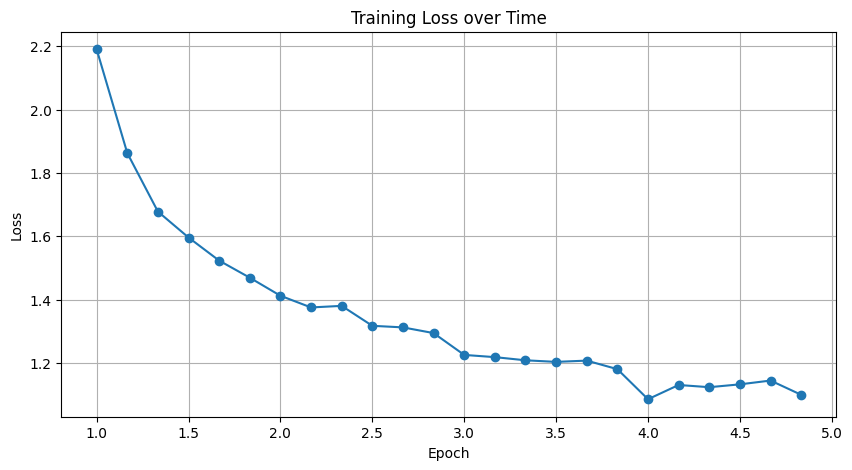

In [ ]:
# Task1 : loss over epochs
import matplotlib.pyplot as plt

# Create a list of the loss values from printed values
loss_values = [2.191, 1.863, 1.678, 1.596, 1.523, 1.469,  # Epoch 1
               1.412, 1.375, 1.380, 1.317, 1.312, 1.294,  # Epoch 2
               1.225, 1.218, 1.208, 1.203, 1.207, 1.180,  # Epoch 3
               1.085, 1.130, 1.123, 1.132, 1.144, 1.099]  # Epoch 4

# Create a corresponding list of epochs
epochs = [i/6 + 1 for i in range(len(loss_values))]

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, marker='o')
plt.title('Training Loss over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


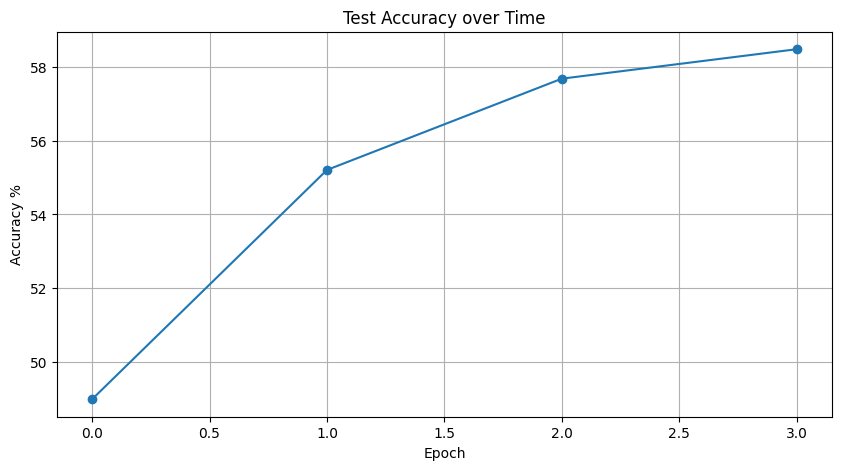

In [ ]:
# Task2: Plot the accuracy over the epochs
plt.figure(figsize=(10, 5))
plt.plot(accuracy_values, marker='o')
plt.title('Test Accuracy over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.grid(True)
plt.show()

In [ ]:
# Task3: Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

[[632  36  51  30  28  27  16   8  93  79]
 [ 14 740   2  11   1   9  15   2  18 188]
 [ 68  12 430  60 128 121 113  16  20  32]
 [ 13  24  68 318  72 277 147  19  13  49]
 [ 30  14  60  82 500  99 119  69  12  15]
 [ 11   8  47 143  71 597  55  39   5  24]
 [  5  22  30  56  50  58 736   3   7  33]
 [ 13   6  34  45 104 135  38 569   4  52]
 [100 104  19  21   9   9  12   3 655  68]
 [ 11 115  14  14  11  12  16   6  26 775]]
[63.2 74.  43.  31.8 50.  59.7 73.6 56.9 65.5 77.5]


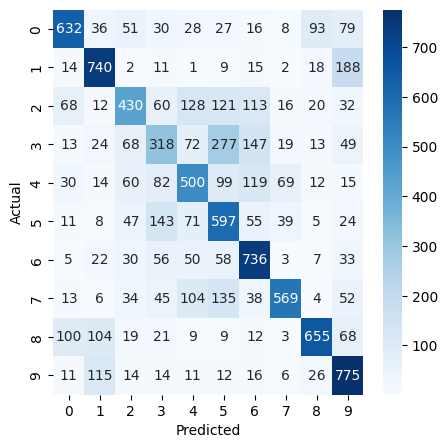

In [ ]:
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Extra Credits (5 pt)
Run VGG with pre-trained weights in this [colab](https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/pytorch_vision_vgg.ipynb#scrollTo=daily-wayne). Test any two images of your choice to your model and to VGG model and show accuracy (images must include objects from CIFAR10 classes). Discuss which model performs better and why.

# Answer:


It seems that my model outperformed the VGG model when tested on both CIFAR-10 images and random images from the internet (ensuring that they include objects from CIFAR10 classes). This can be attributed to several factors. Primarily, my model was specifically trained on the CIFAR-10 dataset and classes, making it better suited for recognizing its particular classes and image types. In contrast, the VGG model was trained on the larger, more diverse ImageNet dataset, potentially making it less effective on CIFAR-10 specific classes. Also, I think image resolution may play a role, as the VGG model is designed for higher-resolution images than those in the CIFAR-10 set. The potential loss of detail when testing the VGG model on these lower resolution images might impact its accuracy.

In [ ]:
# Testing using two random imgs from CIFAR10 dataset

import torchvision.models as models
import torch.nn as nn
import torch

# Load pre-trained VGG model
vgg = models.vgg16(pretrained=True)

# Modify the final layer to match the number of classes in the target dataset
num_features = vgg.classifier[6].in_features
features = list(vgg.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(classes))]) # Add our layer with 10 outputs
vgg.classifier = nn.Sequential(*features) # Replace the model classifier

vgg.to(device)
vgg.eval()  # Set to evaluation mode

# For CIFAR10, the size of the image is 32x32. However, VGG16 requires the input size to be 224x224.
# So, define a transform to resize the images for VGG16.
transform_vgg = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Convert testset to be compatible with VGG
testset_vgg = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_vgg)
testloader_vgg = torch.utils.data.DataLoader(testset_vgg, batch_size=batch_size, shuffle=False, num_workers=2)

# Select four random images
images, labels = next(iter(testloader))
images_vgg, _ = next(iter(testloader_vgg))

# Run the images through my model
outputs = net(images.to(device))
_, predictions = outputs.max(1)
print(f'My model predictions: {[classes[prediction] for prediction in predictions]}, Actual: {[classes[label] for label in labels]}')

# Run the images through the VGG model
outputs = vgg(images_vgg.to(device))
_, predictions = outputs.max(1)
print(f'VGG model predictions: {[classes[prediction] for prediction in predictions]}, Actual: {[classes[label] for label in labels]}')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


My model predictions: ['cat', 'ship', 'plane', 'plane'], Actual: ['cat', 'ship', 'ship', 'plane']
VGG model predictions: ['plane', 'plane', 'plane', 'cat'], Actual: ['cat', 'ship', 'ship', 'plane']


In [ ]:
# Testing using two random imgs from the internet

from PIL import Image
from torchvision.transforms import ToTensor
import urllib.request
import json
import requests


# Load ImageNet class names
imagenet_classes = json.loads(requests.get('https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json').text)

def predict_image(image_path, model, device, transform, classes):
    # Load image
    with urllib.request.urlopen(image_path) as url:
        img = Image.open(url)
    img_t = transform(img)
    # Convert to batch format (B x C x H x W)
    img_t = img_t.unsqueeze(0).to(device)
    # Forward pass
    outputs = model(img_t)
    _, predicted = outputs.max(1)
    return classes[predicted]

# URLs of two images from the internet
url1 = "https://images.unsplash.com/photo-1611003228941-98852ba62227?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8Mnx8YmFieSUyMGRvZ3xlbnwwfHwwfHw%3D&w=1000&q=80"
url2 = "https://media.istockphoto.com/id/521697371/photo/brown-pedigree-horse.jpg?s=612x612&w=0&k=20&c=x19W0K7iuQhQn_7l3wRqWq-zsbo0oRA33C3OF4nooL0="
image_urls = [url1, url2]

# For my model
transform_your_model = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# For VGG
transform_vgg = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

for image_url in image_urls:
    print(f"Image URL: {image_url}")
    print(f'My model prediction: {predict_image(image_url, net, device, transform_your_model, classes)}')
    print(f'VGG model prediction: {predict_image(image_url, vgg, device, transform_vgg, imagenet_classes)}')


Image URL: https://images.unsplash.com/photo-1611003228941-98852ba62227?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8Mnx8YmFieSUyMGRvZ3xlbnwwfHwwfHw%3D&w=1000&q=80
Your model prediction: dog
VGG model prediction: Golden Retriever
Image URL: https://media.istockphoto.com/id/521697371/photo/brown-pedigree-horse.jpg?s=612x612&w=0&k=20&c=x19W0K7iuQhQn_7l3wRqWq-zsbo0oRA33C3OF4nooL0=
Your model prediction: horse
VGG model prediction: common sorrel
